# BTC Trading Algo Notebook

In [10]:
import gymnasium as gym
import gym_trading_env
import numpy as np
import pandas as pd
import datetime
import snowflake.connector
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import deque

In [2]:
with open("..\secrets\snow-connection.yml","r") as file:
    snow_secrets = yaml.safe_load(file)

In [3]:
ctx = snowflake.connector.connect(
    user=snow_secrets["users"]["admin"]["username"],
    password=snow_secrets["users"]["admin"]["password"],
    account=snow_secrets["users"]["admin"]["account"],
    warehouse=snow_secrets["users"]["admin"]["warehouse"],
    role=snow_secrets["users"]["admin"]["role"]
)

In [4]:
cur = ctx.cursor()
cur.execute("SELECT * FROM TF_TEST.DATA.vw_ohlc limit 10000")
df = cur.fetch_pandas_all()
df.head(5)

,TRADE_PAIR,TIMESTAMP,OPEN,HIGH,LOW,CLOSE,VOLUME,TRADES
0,XBTUSD,2019-11-06 11:03:00,9356,9357.2,9355.9,9357.1,0.676458,3
1,XBTUSD,2019-11-06 11:04:00,9357,9360.0,9357.2,9360.0,5.591000,6
2,XBTUSD,2019-11-06 11:05:00,9360,9360.0,9360.0,9360.0,0.031435,1
3,XBTUSD,2019-11-06 11:06:00,9360,9360.0,9360.0,9360.0,0.945198,4
4,XBTUSD,2019-11-06 11:07:00,9360,9365.3,9360.0,9365.3,0.207000,3


In [5]:
df = pd.read_csv('xbtusd_example.csv')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.set_index('TIMESTAMP')
df.drop(['TRADE_PAIR','TRADES'], axis=1, inplace=True)
df.columns = ['open', 'high', 'low', 'close', 'volume']
df.head(5)

,open,high,low,close,volume
TIMESTAMP,,,,,
2022-07-11 02:15:00+00:00,20472,20503.1,20469.3,20497.0,2.274571
2022-07-11 02:16:00+00:00,20493,20494.1,20472.4,20492.0,0.082142
2022-07-11 02:17:00+00:00,20492,20503.3,20492.0,20503.3,0.263507
2022-07-11 02:18:00+00:00,20503,20527.9,20502.9,20517.1,0.332528
2022-07-11 02:19:00+00:00,20517,20520.4,20507.8,20510.3,1.040017


In [6]:
env = gym.make("TradingEnv",
        name= "XBTUSD",
        df = df, # Your dataset with your custom features
        positions = [ -1, 0, 1], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        # borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
    )

In [7]:
# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(position_index)

Market Return :  2.44%   |   Portfolio Return : -60.20%   |   


## Neural Network Approach

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [35]:

# Create the feature : ( close[t] - close[t-1] )/ close[t-1]
df["feature_close"] = df["close"].pct_change()

# Create the feature : open[t] / close[t]
df["feature_open"] = df["open"]/df["close"]

# Create the feature : high[t] / close[t]
df["feature_high"] = df["high"]/df["close"]

# Create the feature : low[t] / close[t]
df["feature_low"] = df["low"]/df["close"]

# Create the feature : volume[t] / max(*volume[t-7*24:t+1])
df["feature_volume"] = df["volume"] / df["volume"].rolling(7*24).max()

df.dropna(inplace= True) # Clean again !

In [36]:
env = gym.make("TradingEnv",
        name= "XBTUSD",
        df = df, # Your dataset with your custom features
        positions = [0, 1], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        # borrow_interest_rate= 0.a0003/100, # 0.0003% per timestep (one timestep = 1h here)
        initial_position = 0, # 0 = OUT
    )

In [37]:
env.observation_space.shape

(7,)

In [38]:
state = env.reset()
state

(array([0.0000000e+00, 1.0000147e+00, 1.0000000e+00, 1.0000000e+00,
        2.7655262e-06, 0.0000000e+00, 0.0000000e+00], dtype=float32),
 {'idx': 0,
  'step': 0,
  'date': numpy.datetime64('2022-07-11T05:02:00.000000000'),
  'position_index': 0,
  'position': 0,
  'real_position': 0,
  'data_volume': 0.0001,
  'data_high': 20519.7,
  'data_open': 20520.0,
  'data_low': 20519.7,
  'data_close': 20519.7,
  'portfolio_valuation': 1000.0,
  'portfolio_distribution_asset': 0,
  'portfolio_distribution_fiat': 1000.0,
  'portfolio_distribution_borrowed_asset': 0,
  'portfolio_distribution_borrowed_fiat': 0,
  'portfolio_distribution_interest_asset': 0,
  'portfolio_distribution_interest_fiat': 0,
  'reward': 0})

In [47]:
observation, reward, done, truncated, info = env.step(1)

In [48]:
print(f"observation: {observation}")
print(f"reward: {reward}")
print(f"done: {done}")
print(f"truncated: {truncated}")
print(f"info: {info}")


observation: [2.4367184e-05 1.0000049e+00 1.0000000e+00 1.0000000e+00 7.9545827e-04
 1.0000000e+00 1.0000000e+00]
reward: 2.4366887350704495e-05
done: False
truncated: False
info: {'idx': 8, 'step': 8, 'date': numpy.datetime64('2022-07-11T05:10:00.000000000'), 'position_index': 1, 'position': 1, 'real_position': 1.0, 'data_volume': 0.02876336, 'data_high': 20519.9, 'data_open': 20520.0, 'data_low': 20519.9, 'data_close': 20519.9, 'portfolio_valuation': 999.9097457565169, 'portfolio_distribution_asset': 0.048728782584540706, 'portfolio_distribution_fiat': 0, 'portfolio_distribution_borrowed_asset': 0, 'portfolio_distribution_borrowed_fiat': 0, 'portfolio_distribution_interest_asset': 0, 'portfolio_distribution_interest_fiat': 0, 'reward': 2.4366887350704495e-05}


## Neural Network Example

In [78]:
# torch.set_default_device('cuda')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                        
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 240)
        self.fc2 = nn.Linear(240, 240)
        self.fc3 = nn.Linear(240, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.batch_size = 32

        self.model = DQN(state_dim, action_dim).to(self.device)
        self.target_model = DQN(state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.update_target_model()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state = torch.FloatTensor(next_state).to(self.device)
                target += self.gamma * torch.max(self.target_model(next_state)).item()
            state = torch.FloatTensor(state).to(self.device)
            target_f = self.model(state)
            target_f = target_f.clone()  # Detach the target tensor from the computation graph
            target_f[0][action] = target  # Proper indexing to set the target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
def save_results(episode_results, filename="results.csv"):
    df = pd.DataFrame(episode_results, columns=["Episode", "Score"])
    df.to_csv(filename, index=False)
    print(f"Results saved to {filename}")

def plot_results(episode_results):
    df = pd.DataFrame(episode_results, columns=["Episode", "Score"])
    plt.plot(df["Episode"], df["Score"])
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.title("Training Performance Over Episodes")
    plt.show()


In [79]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim)
episodes = 100
episode_results = []
episode_length = 500

for e in range(episodes):
    state = env.reset()
    state = np.reshape(state[0], [1, state_dim])
    for time in range(episode_length):
        action = agent.act(state)
        next_state, reward, done, truncated, info = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_dim])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if time == episode_length-1:
            agent.update_target_model()
            episode_results.append((e, info['portfolio_valuation']))
            print(f"Episode: {e}/{episodes}, Portfolio: {info['portfolio_valuation']}")
            break
        agent.replay()
        # print(f"Episode: {e}/{episodes}, Time: {time}, Epsilon: {agent.epsilon:.2}, Action: {action}, Reward: {reward}")
        print(f"Step: {info['step']}, {info['portfolio_valuation']}")
env.close()


Step: 1, 999.7560618627116
Step: 2, 999.6560862565253
Step: 3, 1000.2288842744837
Step: 4, 1000.1288613860562
Step: 5, 999.7119354137446
Step: 6, 999.5070579664927
Step: 7, 999.407107260696
Step: 8, 999.268201129766
Step: 9, 999.0634977694185
Step: 10, 998.9635804539693
Step: 11, 998.9635804539693
Step: 12, 997.6709425417205
Step: 13, 997.5709268955932
Step: 14, 997.6022120682424
Step: 15, 997.5024680790947
Step: 16, 997.8295673394921
Step: 17, 997.9944826136744
Step: 18, 997.6784763682672
Step: 19, 997.4789606245679
Step: 20, 997.5609559824553
Step: 21, 997.5609559824553
Step: 22, 997.0848812081994
Step: 23, 996.985107426194
Step: 24, 997.326562280449
Step: 25, 997.2289011763327
Step: 26, 997.0294757529501
Step: 27, 997.0149350834125
Step: 28, 996.9152335899042
Step: 29, 996.8107060905776
Step: 30, 996.6064980523479
Step: 31, 996.5068374025427
Step: 32, 996.237529447554
Step: 33, 996.1378617943969
Step: 34, 996.4210849449823
Step: 35, 996.4210849449823
Step: 36, 996.7649281115741
Step

KeyboardInterrupt: 

In [43]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

Results saved to results.csv


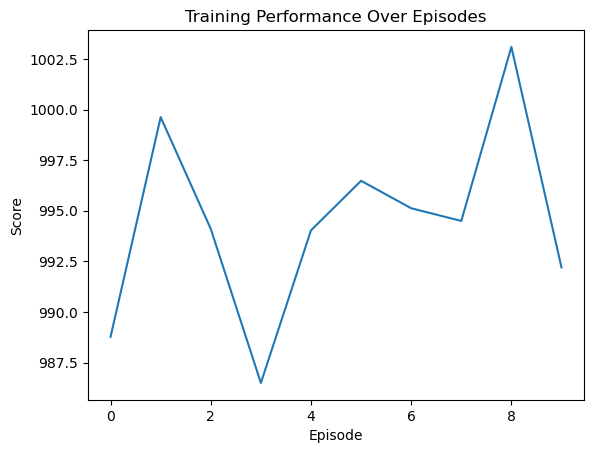

In [ ]:
save_results(episode_results)
plot_results(episode_results)